# Supply Chain Management Models

In supply chain management, we are concerned with how much we should order to meet demand.

### Table of Contents
1. [Economic Order Quantity (Deterministic Demand)](#eoq)
2. [Newsvendor Model (Probabilistic Demand)](#newsvendor)
3. [Economic Order Quantity with Uncertainty and Lead Time (Probabilistic Demand)](#hybrid)

In [93]:
# Imports
%matplotlib notebook

import sys
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
from graphviz import Digraph
import seaborn as sns

sns.set_style('darkgrid')
np.random.seed(42)

---
## Economic Order Quantity (Deterministic Demand)<a id='eoq'></a>

This has many implications but in terms of financials, it'll help us figure out the optimal quantity to order to minimize total annual cost and COGS per quarter, which will affect the Profit & Loss statement.

$$
\begin{aligned}
\text{Annual Total Cost} 
&= \text{Annual Purchase Cost} + \underbrace{\text{Annual Inventory-related Cost}}_{
\underbrace{\text{Annual Ordering Cost}}_{
\text{Number of Orders Placed}\,\times\,\text{Ordering Cost}}
+ 
\underbrace{\text{Annual Holding Cost}}_{
\underbrace{\text{Average Inventory in Storage (WIP)}}_{
\begin{aligned}
&\text{By Little's Law}, \\
\text{WIP}\,&=\,\text{Flow Rate}\,\times\,\text{Flow Time}
\end{aligned}
}\,\times\,\text{Holding Cost}}
} \\
\end{aligned}
$$

### Assumptions
1. Delivery and storage of inventory after order is placed is immediate
2. Holding cost for inventory is on-demand (e.g. If holding cost for 1 T-shirt is \\$1, holding cost for 2 T-shirts is \\$2, meaning there is no fixed cost for inventory storage)
3. Demand rate is constant and known
4. Order multiple times

### Variables
- Annual Demand $D$
- Per-unit Product Cost $C$
- Ordering Cost $S$
- Batch-size (Order Quantity) $Q$
- Annual Per-unit Holding Cost $H$

### Minimize Annual Inventory Cost

In order to minimize our Annual Inventory-related Cost, we'll set up the equation for it, take the derivative and set it to 0.

$$
\begin{aligned}
\text{Annual Inventory-related Cost} &= \text{Annual Ordering Cost} + \text{Annual Holding Cost} \\
C(Q) &= \text{Number of Orders Placed}\,\frac{D}{Q}\,\times\,\text{Ordering Cost}\,S + \text{Average Inventory in Storage (WIP)}\,\frac{Q}{2}\,\times\,\text{Holding Cost}\,H\\
\end{aligned}
$$

Set derivative to 0 to get minima:
$$
\begin{aligned}
\frac{d}{dQ}\Big(\frac{D}{Q} \times S + \frac{Q}{2} \times H \Big) &= 0 \\
-DSQ^{-2} + \frac{H}{2} &= 0 \\
-\frac{H}{2} &= \frac{DS}{Q^2} \\
Q^2 &= \frac{2DS}{H} \\
Q^* &= \sqrt{\frac{2DS}{H}}
\end{aligned}
$$

We now have the Optimal Quantity to purchase $Q^*$ to minimize the total annual inventory cost.

Annual Inventory-related Cost: 

$$
\begin{aligned}
C(Q^*) &= \frac{D}{Q^*}S + \frac{Q^*}{2}H \\
&= \frac{D}{\sqrt{\frac{2DS}{H}}}S + \frac{\sqrt{\frac{2DS}{H}}}{2}H \\
&= \sqrt{2DSH}
\end{aligned}
$$

<IPython.core.display.Javascript object>


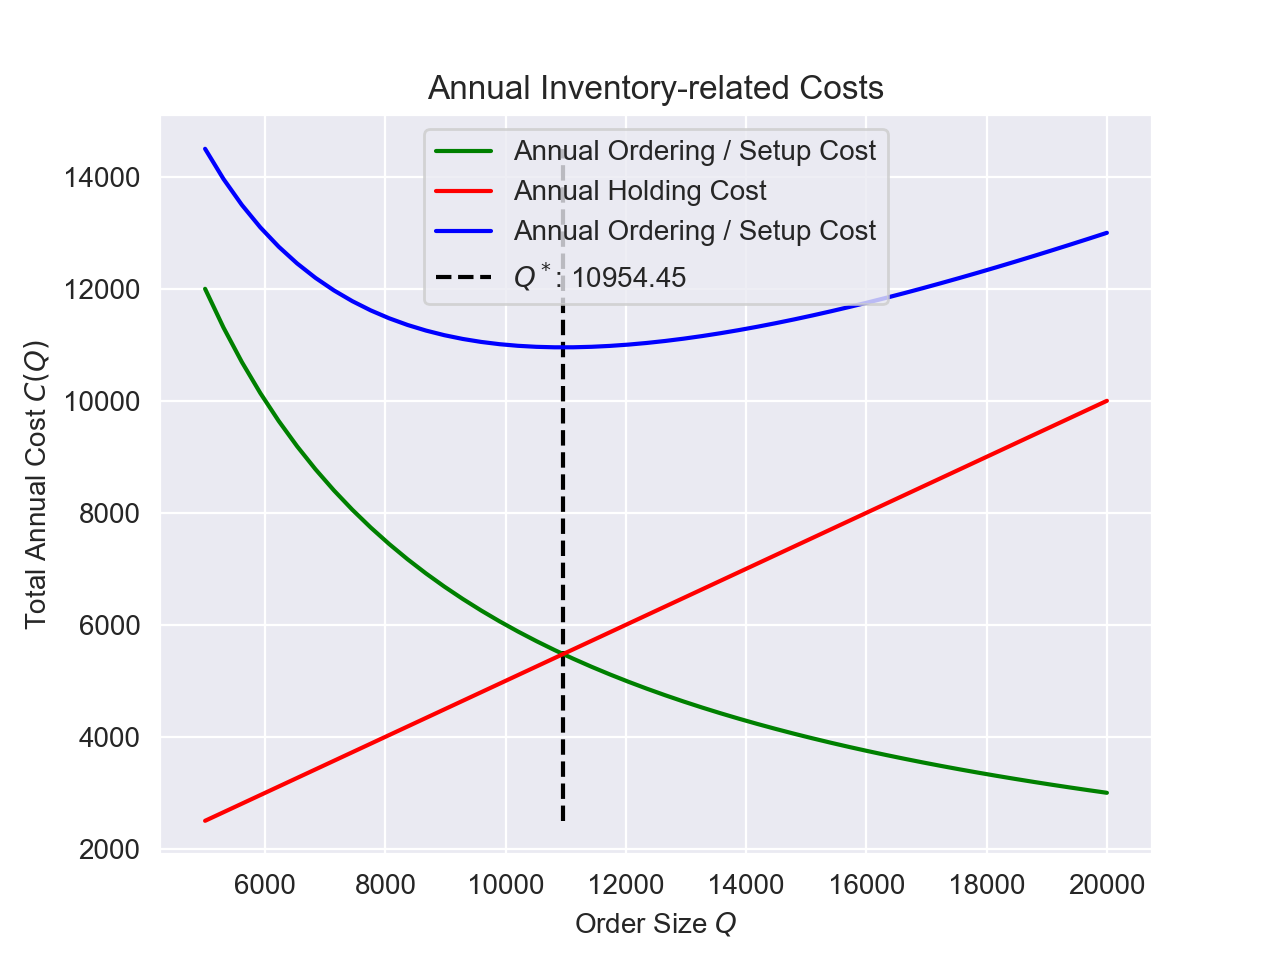

In [143]:
"""
E.g. 
1. We are selling T-shirts
2. Demand is known to be fixed at 120,000 annually
3. Ordering cost is fixed to be $500
4. The per-unit holding / storage cost for a single T-shirt is $1
"""
######################
##### VARIABLES ######
######################
D = 120000
S = 500
H = 1
Q = np.linspace(5000, 20000)
Q_opt = (2*D*S/H)**0.5

# Plot figure
fig, ax = plt.subplots(1, 1)
ax.plot(Q, D*S/Q, c='g', label='Annual Ordering / Setup Cost')
ax.plot(Q, Q*H/2, c='r', label='Annual Holding Cost')
ax.plot(Q, (D*S/Q) + (Q*H/2), c='b', label='Annual Ordering / Setup Cost')
ax.vlines(x=Q_opt, 
          ymin=np.min(Q*H/2),
          ymax=np.max((D*S/Q) + (Q*H/2)),
          linestyles='--', 
          label='$Q^*$: {}'.format(round(Q_opt, 2)))
ax.set_ylabel('Total Annual Cost $C(Q)$')
ax.set_xlabel('Order Size $Q$')
ax.set_title('Annual Inventory-related Costs')
ax.legend()

plt.show();

### Economies of Scale

The increase in annual inventory cost is less than proportionate to the increase in demand.

---
## Newsvendor Model (Probabilistic Demand)<a id='newsvendor'></a>

We will derive the newsvendor model via **marginal analysis**. This model should be used when inventory items are perishable / risk spoilage. While in EOQ, we got the optimal quantity $Q^*$ by minimizing total annual inventory-related cost, in the newsvendor model, we get the optimal quantity $Q^*$ by comparing the difference in expected profit between ordering $Q$ and $Q-1$.

### Assumptions
1. Delivery and storage of inventory after order is placed is immediate
2. Holding cost for inventory is negligible
3. Demand rate is **random** and **uncertain**
4. Order ony **once**

### Variables
- Demand $D \sim \mathcal{N}(\mu_D, \sigma_D)$
- Order Quantity $Q$
- Purchase Cost $c$
- Selling Price $p$
- Salvage Value $v$
- Goodwill Cost $g$

### Marginal Analysis

Let's consider if we order $Q$ Vs. $Q-1$.

If we order $Q$:
1. With $P(D \geq Q)$, we will sell the $Q^{th}$ unit, resulting in a profit of $p - c$
2. With $1 - P(D \geq Q)$, we won't sell the $Q^{th}$ unit, resulting in a profit of $v - c$

$$
\begin{aligned}
\mathbb{E}[\text{Order }Q] 
&= 
\begin{bmatrix} P(D \geq Q) & 1 - P(D \geq Q) \end{bmatrix} 
\cdot
\begin{bmatrix} p - c \\ v - c \end{bmatrix} \\
&=
\begin{bmatrix} 1 - P(D < Q) & P(D < Q) \end{bmatrix} 
\cdot
\begin{bmatrix} p - c \\ v - c \end{bmatrix}
\end{aligned}
$$

If we order $Q-1$:
1. With $P(D \geq Q)$, we will stockout because there are insufficient units, resulting in a loss of $g$
2. With $1 - P(D \geq Q)$, we did not over-order, resulting in a loss of $0$

$$
\begin{aligned}
\mathbb{E}[\text{Order }Q - 1] 
&= 
\begin{bmatrix} P(D \geq Q) & 1 - P(D \geq Q) \end{bmatrix} 
\cdot
\begin{bmatrix} -g \\ 0 \end{bmatrix} \\
&=
\begin{bmatrix} 1 - P(D < Q) & P(D < Q) \end{bmatrix} 
\cdot
\begin{bmatrix} -g \\ 0 \end{bmatrix}
\end{aligned}
$$

Hence, we will only order $Q$ if $\mathbb{E}[\text{Order }Q] \geq \mathbb{E}[\text{Order }Q - 1]$:

$$
\begin{aligned}
\mathbb{E}[\text{Order }Q] &\geq \mathbb{E}[\text{Order }Q - 1] \\
1 - P(D \geq Q) &\leq \frac{p - c + g}{(p - c + g) + (c - v)} \\
P(D < Q) &\leq \underbrace{\frac{C_u}{C_u + C_o}}_{\text{Indifference Level}}
\end{aligned}
$$

- $C_u = p - c + g$ is known as the **underage cost**: Cost/unit of underestimating the realized demand
- $C_o = c - v$ is known as the **overage cost**: Cost/unit of overestimating the realized demand

<IPython.core.display.Javascript object>


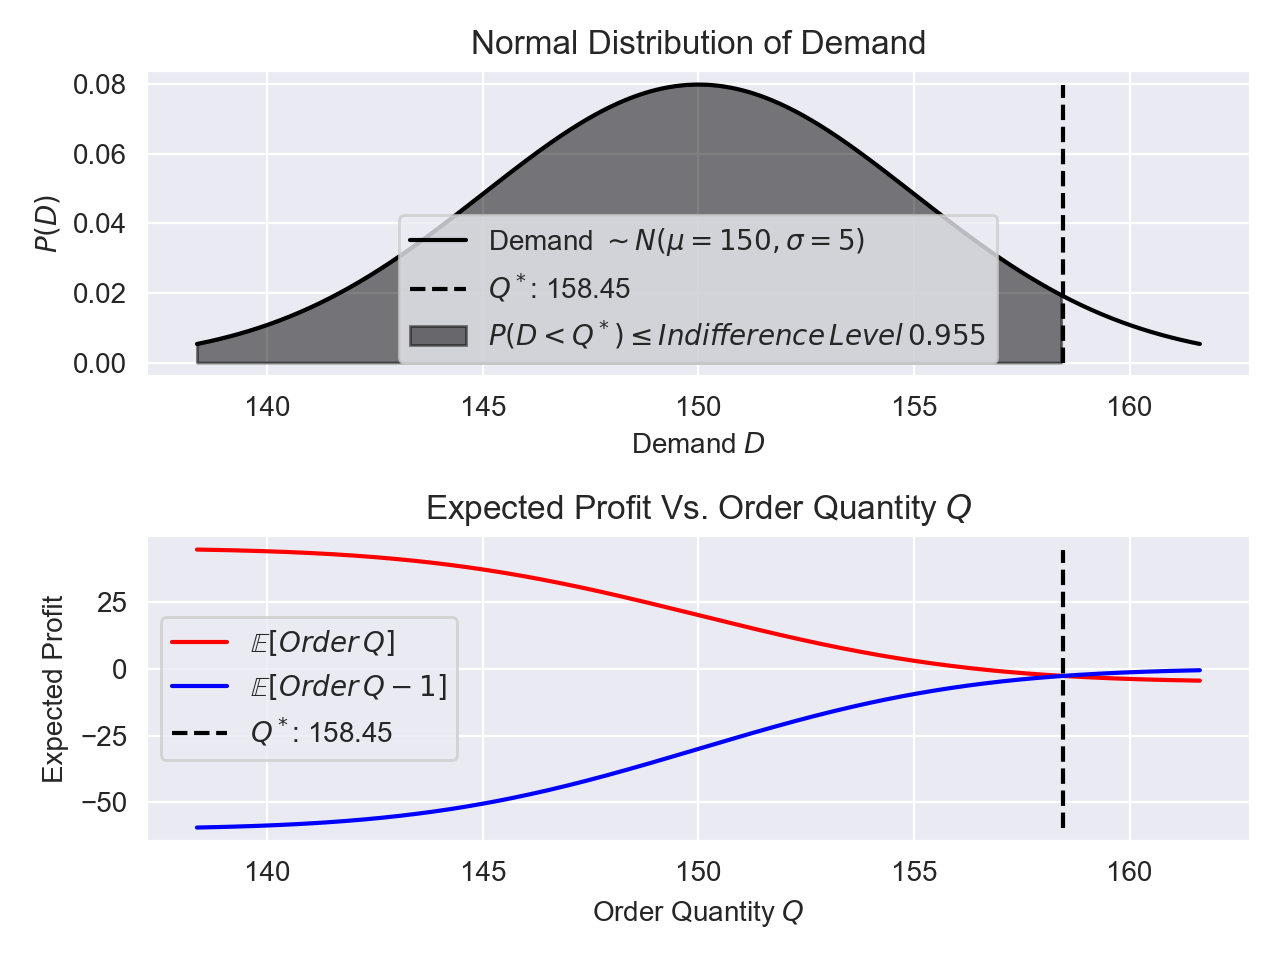

In [141]:
"""
E.g. 
1. We are selling flu vaccines @ $50 that cost $5. 
2. All unsold vaccines are worthless $0 at the end of the flu season.
3. If we stock-out and people can't buy the vaccine, we take a goodwill loss to 
our clinic name of $60.
4. Demand from historical data is normal with mean 150, and standard deviation 5
"""
######################
##### VARIABLES ######
######################
mu_D = 150
sigma_D = 5
D = scipy.stats.norm(loc=mu_D, scale=sigma_D) # Demand Distribution
c = 5 # Purchase cost
p = 50 # Selling price
v = 0 # Salvage value
g = 60 # Goodwill cost
C_u = p - c + g # Underage cost
C_o = c - v # Overage cost

# Optimal Quantity to order
# (Critical value @ Indifference Level)
Q_opt = round(
    D.ppf(C_u / (C_u + C_o)),
    2
)

# Order Quantities
Q = np.linspace(
    start=D.ppf(0.01),
    stop=D.ppf(0.99), 
    num=500
)

# Plot figure
fig, ax = plt.subplots(2, 1)

########################################
##### 1. PLOT NORMAL DISTRIBUTION ######
########################################
# Plot Normal Distribution of Demand
ax[0].plot(Q, D.pdf(Q), 
           c='black', 
           label='Demand $\sim N(\mu={0}, \sigma={1})$'.format(mu_D, sigma_D))

# Plot Critical Value / # Optimal Quantity to order
# so that cdf till Critical Value = Indifference Level
ax[0].vlines(x=Q_opt, 
             ymin=0, 
             ymax=np.max(D.pdf(Q)),
             linestyles='--', 
             label='$Q^*$: {}'.format(Q_opt))
ax[0].fill_between(Q, 
                   D.pdf(Q), 
                   where=(Q < Q_opt),
                   alpha=.5, color='black', 
                   label='$P(D < Q^*) \leq Indifference\,Level\,{}$'.format(round(C_u / (C_u + C_o), 3)))
ax[0].set_ylabel('$P(D)$')
ax[0].set_xlabel('Demand $D$')
ax[0].set_title('Normal Distribution of Demand')
ax[0].legend()

#####################################################
##### 2. PLOT EXPECTED ORDER QUANTITY BENEFITS ######
#####################################################
expected_profit_order_Q = [np.dot(probs, [p - c, v - c]) \
                           for probs in zip(1-D.cdf(Q), D.cdf(Q))]

expected_profit_order_Q_1_less = [np.dot(probs, [-g, 0]) \
                                  for probs in zip(1-D.cdf(Q), D.cdf(Q))]

ax[1].plot(Q, expected_profit_order_Q, 
           c='r', 
           label='$\mathbb{E}[Order\,Q]$')

ax[1].plot(Q, expected_profit_order_Q_1_less, 
           c='b', 
           label='$\mathbb{E}[Order\,Q-1]$')

# Plot Critical Value / # Optimal Quantity to order
# so that cdf till Critical Value = Indifference Level
ax[1].vlines(x=Q_opt,
             ymin=np.min(expected_profit_order_Q_1_less), 
             ymax=np.max(expected_profit_order_Q),
             linestyles='--', 
             label='$Q^*$: {}'.format(Q_opt))

ax[1].set_ylabel('Expected Marginal Profit from Ordering 1 more unit')
ax[1].set_xlabel('Order Quantity $Q$')
ax[1].set_title('Expected Marginal Profit from Ordering 1 more unit Vs. Order Quantity $Q$')
ax[1].legend()

plt.tight_layout()
plt.show();

### Analysis

$Q^* = 158.45$ is the largest quantity we can order such that we meet the demand $95.5\%$ of the time. By meeting demand $95.5\%$, we ensure that the benefits / cons from ordering 1 more unit of flu vaccine are negligible, hence we are indifferent. Ordering any more quantity past the critical value of the indifference level does allow us to meet demand a higher percentage of the time, but we don't actually get more marginal profit from doing this.

### Relationship to EOQ

Doing this maximizes the total expected profit because finding the point where $\mathbb{E}[\text{Order }Q] = \mathbb{E}[\text{Order }Q - 1]$ is essentially the same as finding the point where the gradient / derivative of total expected profit = 0, which is the same as what we did in EOQ. Hence, we see that the EOQ and Newsvendor model are based on the similar principle. EOQ minimizes annual inventory cost while Newsvendor maximizes the expected total profit and both get the optimal order quantity $Q^*$ by setting their respective objective function gradients to 0.

---
## EOQ with Uncertainty and Lead Time (Probabilistic Demand)<a id='hybrid'></a>

We will update the EOQ model to be more realistic, when demand is a forecasted value and not fixed.

Things to Remember
- Variances are additive
- A $z$-score is the number of standard deviations $\sigma$ from the mean $\mu$

### Assumptions
1. Delivery and storage of inventory after order is placed is **not** immediate, there is a **lead time** (how long it takes for inventory to be delivered and stored)
2. Holding cost for inventory is on-demand (e.g. If holding cost for 1 T-shirt is \\$1, holding cost for 2 T-shirts is \\$2, meaning there is no fixed cost for inventory storage)
3. Demand rate is **random** and **uncertain**
4. Order multiple times

### Variables
- Annual Demand $D$, Daily Demand $d \sim \mathcal{N}(\mu_d, \sigma_d)$
- Per-unit Product Cost $C$
- Ordering Cost $S$
- Batch-size (Order Quantity) $Q$
- Annual Per-unit Holding Cost $H$
- Lead Time $L$

### Re-Order Point

The biggest 2 differences between this scenario and the EOQ model scenario is that we have to account for the lead time and demand is variable. This means that after we order, we'll still have to accomodate the probabilistic demand while waiting for the new stock to arrive. Hence, we can't re-order new inventory right when we finish stock, but we have to do that earlier, precisely earlier by the amount of lead time for the new stock to arrive after reordering. We call this point the **Reorder Point (ROP)**.

If we did not have variability in demand, but only the lead time to account for, we just have to make sure we have enough stock to cover the $L$ days of Daily Demand $d$:

$$
\begin{aligned}
\text{ROP} &= L \times d
\end{aligned}
$$

However, if our demand is variable, we'll want to have some **safety stock** to make sure that we can accomodate extra demand:

$$
\begin{aligned}
\text{ROP} &= L \times d + \underbrace{z \times \sigma_L}_{\text{Safety Stock}} \\
&= L \times d + \underbrace{z \times \sqrt{L\sigma_d^2}}_{\text{Safety Stock}} \because \text{Variance is Additive} \therefore \sigma_L^2 = L \times \sigma_d^2 \\
\end{aligned}
$$

Since the daily demand $d \sim \mathcal{N}(\mu_d, \sigma_d)$, the ROP = $L$-day demand = $Ld \sim \mathcal{N}(L\mu_d, (\sqrt{L})\sigma_d)$. The $z$-score here is the critical value at $P(Ld < ROP)$ -- the percentage of time we want to be able to meet demand in the lead time period (period of time when we're awaiting arrival of new stock after reordering).

### Optimal Order Quantity $Q^*$

Our $Q^*$ remains the same as the original EOQ at $\sqrt{\frac{2DS}{H}}$

### Average Inventory Level

$$
\begin{aligned}
\text{WIP} &= \Big(\frac{(Q^* + \text{Safety Stock}) + \text{Safety Stock}}{2}\Big) \\
&= \Big(\frac{Q^*}{2}\Big) + \text{Safety Stock} \\
&= \Big(\frac{Q^*}{2}\Big) + z \times \sqrt{L\sigma_d^2}
\end{aligned}
$$

We start off with having $Q^* + \text{Safety Stock}$, and in expectation, we don't touch the safety stock unless demand is too high.

---
### Resources
- [Additivity of Variance Proof](https://apcentral.collegeboard.org/courses/ap-statistics/classroom-resources/why-variances-add-and-why-it-matters)